In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

Text(0.5, 0.98, 'Time series')

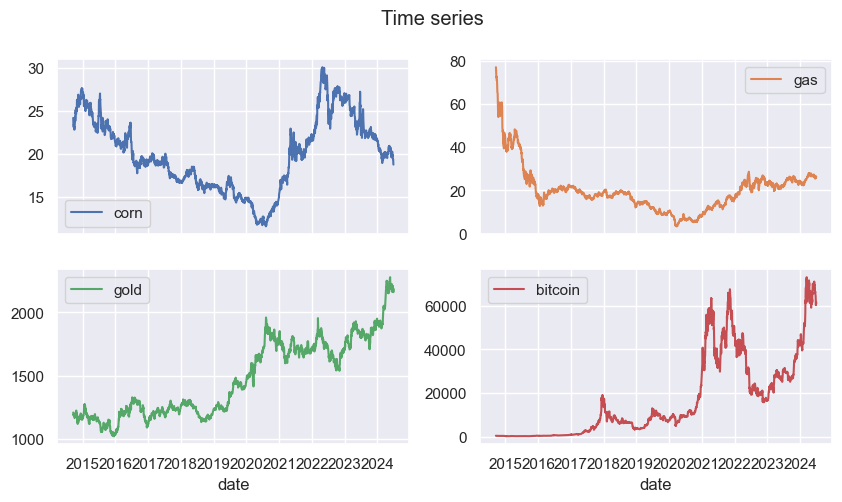

In [2]:
data = pd.read_pickle("data/data.pkl")
(data
 .plot(subplots=True, layout=(2, 2), figsize=(10, 5))
 [0, 0]
 .get_figure()
 .suptitle("Time series")
 )

# Train/test split

In [3]:
split = int(0.7 * data.shape[0])
train, test = data.iloc[:split], data.iloc[split:]

# Fractional Differencing

In [4]:
from src.fractional import optimal_frac_differencing, frac_diff

In [5]:
difference_range = np.arange(0, 1, 0.05)
optimal_differencing = pd.concat(
    [
        optimal_frac_differencing(train[name], difference_range).rename(name)
        for name in train.columns
    ],
    axis=1,
)
optimal_differencing.head()

,corn,gas,gold,bitcoin
0.00,0.495300,3.427614e-04,0.896837,0.740181
0.05,0.345414,1.630816e-04,0.790081,0.663379
0.10,0.196196,8.001582e-05,0.662179,0.572031
0.15,0.082654,3.590785e-06,0.464043,0.498960
0.20,0.081299,8.498556e-07,0.252272,0.384744


Text(0, 0.5, 'ADF p-value')

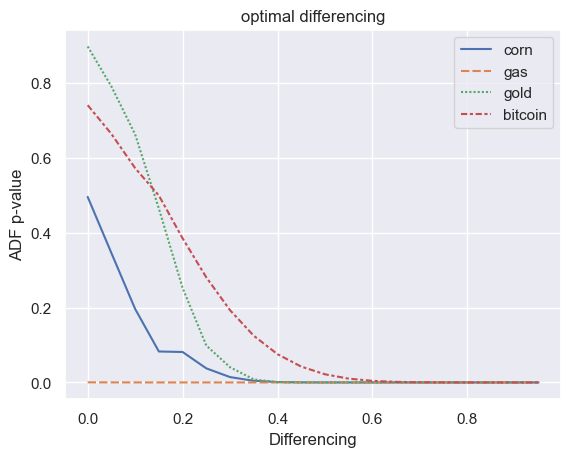

In [6]:
ax = sns.lineplot(optimal_differencing)
ax.set_title("optimal differencing")
ax.set_xlabel("Differencing")
ax.set_ylabel("ADF p-value")

### To replicate the paper, we will choose the optimal values given by the authors.

In [17]:
differencing = {
    "bitcoin": 0.35,
    "gold": 0.15,
    "corn": 0.2,
    "gas": 0.1
}

In [33]:
def differentiate(data: pd.DataFrame, order: dict):
    return (
        pd.DataFrame(
            np.array(
                [
                    frac_diff(data[ticker], value)
                    for ticker, value in differencing.items()
                ]
            ).T,
            index=data.index,
            columns=differencing.keys(),
        )
        .assign(date=lambda df: pd.to_datetime(df.index))
        .set_index("date")
    )

differentiated = differentiate(train, differencing)
differentiated_test = differentiate(test, differencing)
differentiated.head()

,bitcoin,gold,corn,gas
date,,,,
2014-09-17,-7717.684672,-121.864177,5.762185,57.870292
2014-09-18,-5049.389049,-114.544634,4.439748,50.880672
2014-09-19,-4189.633526,-112.631780,3.572774,47.582131
2014-09-22,-3685.322762,-110.117265,3.207789,43.314128
2014-09-23,-3328.948512,-97.439850,2.825539,42.402648


Text(0.5, 0.98, 'Differentiated Time series')

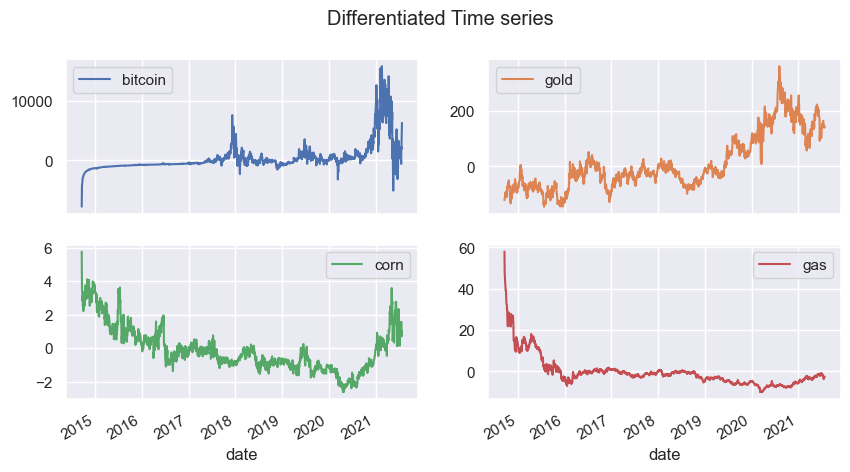

In [9]:
(differentiated
 .plot(subplots=True, layout=(2, 2), figsize=(10, 5))
 [0, 0]
 .get_figure()
 .suptitle("Differentiated Time series")
 )

# Labelling the data

In [10]:
from src.labelling import triple_barrier_labeling

In [23]:
train["labels"] = triple_barrier_labeling(train["bitcoin"], 0.01, -0.01, pd.Timedelta(days=10)).dropna()
test["labels"] = triple_barrier_labeling(test["bitcoin"], 0.01, -0.01, pd.Timedelta(days=10)).dropna()
train.head()

,corn,gas,gold,bitcoin,labels
date,,,,,
2014-09-17,24.150000,76.965027,1209.920044,457.334015,-1.0
2014-09-18,23.980000,75.762436,1198.959961,424.440002,-1.0
2014-09-19,23.540001,74.947800,1191.459961,394.795990,1.0
2014-09-22,23.350000,72.193520,1187.359985,402.152008,1.0
2014-09-23,23.080000,72.131424,1195.099976,435.790985,-1.0


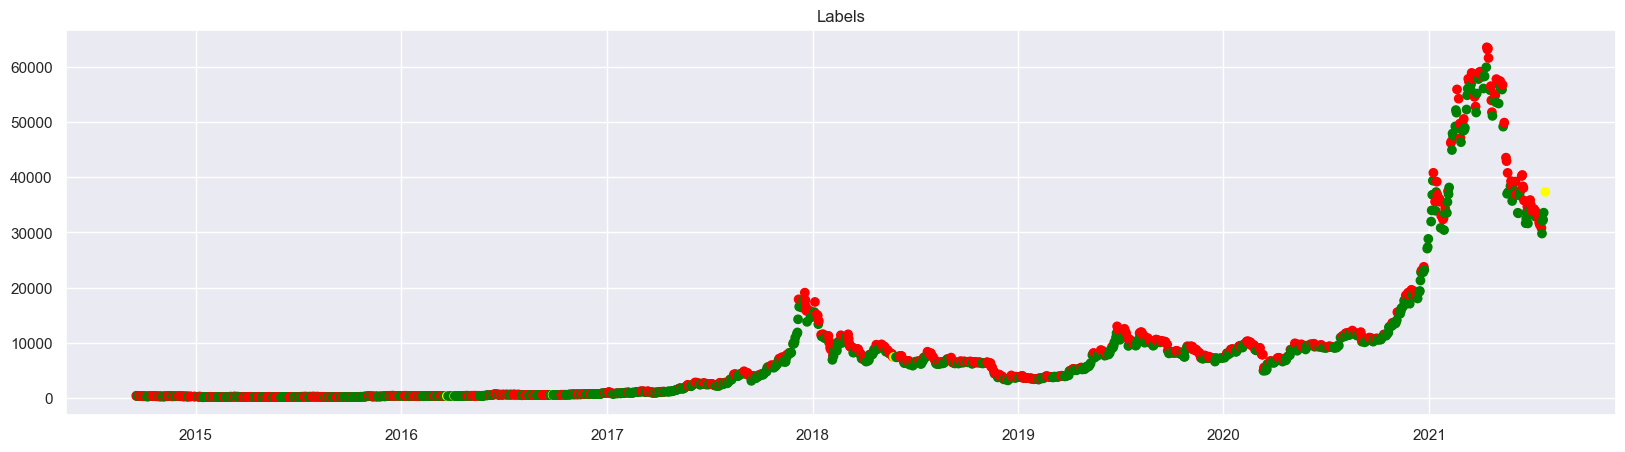

In [24]:
plt.figure(figsize=(20, 5))
plt.title("Labels")
plt.scatter(train.index, train["bitcoin"], c=train["labels"].replace({1: "green", 0: "yellow", -1: "red"}))

# Model Fitting

In [13]:
from src.model import fit_sae_mlp, predict_sae_mlp_classification

In [66]:
def align(y, X: pd.DataFrame):
    mask = np.isfinite(y) & ~X[X_names].isna().any(axis=1)
    return y[mask], X[mask]

In [67]:
X_names = ["corn", "gold", "gas"]
hidden_dims_sae = [16, 8]
hidden_dims_mlp = [8, 4]
output_dim = 3  # Change to the number of classes for classification problems
y, X = align(train["labels"],differentiated[X_names].loc[train.index, :])
sae, mlp = fit_sae_mlp(
    X.values,
    y.values + 1,  # Class labels starts from 0
    hidden_dims_sae,
    hidden_dims_mlp,
    output_dim,
)

Epoch [1/100], SAE Loss: 3254.2698
Epoch [2/100], SAE Loss: 1952.3406
Epoch [3/100], SAE Loss: 1613.3917
Epoch [4/100], SAE Loss: 1058.3711
Epoch [5/100], SAE Loss: 622.6708
Epoch [6/100], SAE Loss: 938.6792
Epoch [7/100], SAE Loss: 772.8068
Epoch [8/100], SAE Loss: 421.3493
Epoch [9/100], SAE Loss: 1119.3083
Epoch [10/100], SAE Loss: 877.2802
Epoch [11/100], SAE Loss: 616.1443
Epoch [12/100], SAE Loss: 1244.1379
Epoch [13/100], SAE Loss: 1004.0959
Epoch [14/100], SAE Loss: 892.9567
Epoch [15/100], SAE Loss: 290.0753
Epoch [16/100], SAE Loss: 1153.1920
Epoch [17/100], SAE Loss: 347.3486
Epoch [18/100], SAE Loss: 1897.9900
Epoch [19/100], SAE Loss: 1161.0084
Epoch [20/100], SAE Loss: 511.8941
Epoch [21/100], SAE Loss: 621.9116
Epoch [22/100], SAE Loss: 1008.3918
Epoch [23/100], SAE Loss: 754.3922
Epoch [24/100], SAE Loss: 1140.1537
Epoch [25/100], SAE Loss: 972.6296
Epoch [26/100], SAE Loss: 1057.1443
Epoch [27/100], SAE Loss: 645.8665
Epoch [28/100], SAE Loss: 828.6181
Epoch [29/100], 

# Evaluation

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [68]:
y, X = align(test["labels"], differentiated_test[X_names])
pred = predict_sae_mlp_classification(sae, mlp, X[X_names].values)

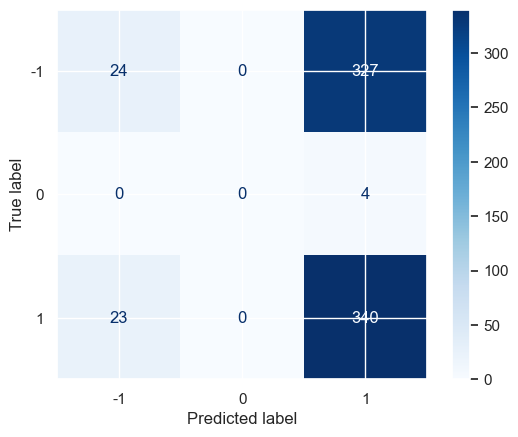

In [81]:
cm = confusion_matrix(y + 1, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
disp.plot(cmap=plt.cm.Blues)

# Backtest

In [113]:
from skfolio import Portfolio, Population

In [104]:
test["position"] = pd.Series(pred - 1, X.index).ffill()
test.head()

,corn,gas,gold,bitcoin,labels,position,returns,pft_returns,bitcoin_returns
date,,,,,,,,,
2021-07-27,20.250000,12.846313,1713.400024,39406.941406,1.0,1.0,NaN,NaN,NaN
2021-07-28,20.250000,13.119831,1712.599976,39995.906250,1.0,1.0,0.014946,0.014946,0.014946
2021-07-29,20.450001,13.101595,1739.400024,40008.421875,1.0,1.0,0.000313,0.000313,0.000313
2021-07-30,20.120001,12.882781,1735.000000,42235.546875,-1.0,1.0,0.055666,0.055666,0.055666
2021-08-02,20.610001,12.591026,1726.400024,39201.945312,-1.0,1.0,-0.071826,-0.071826,-0.071826


### In the paper, the authors assume that we can trade at todays close. Given market hours, this seems unlikely but we follow the same hypothesis.

In [105]:
test = (test
        .assign(
            bitcoin_returns=test["bitcoin"].pct_change(),
            pft_returns=lambda df: df["bitcoin_returns"] * df["position"]
            )
        )

<Axes: title={'center': 'Portfolio Returns [Test set]'}, xlabel='date'>

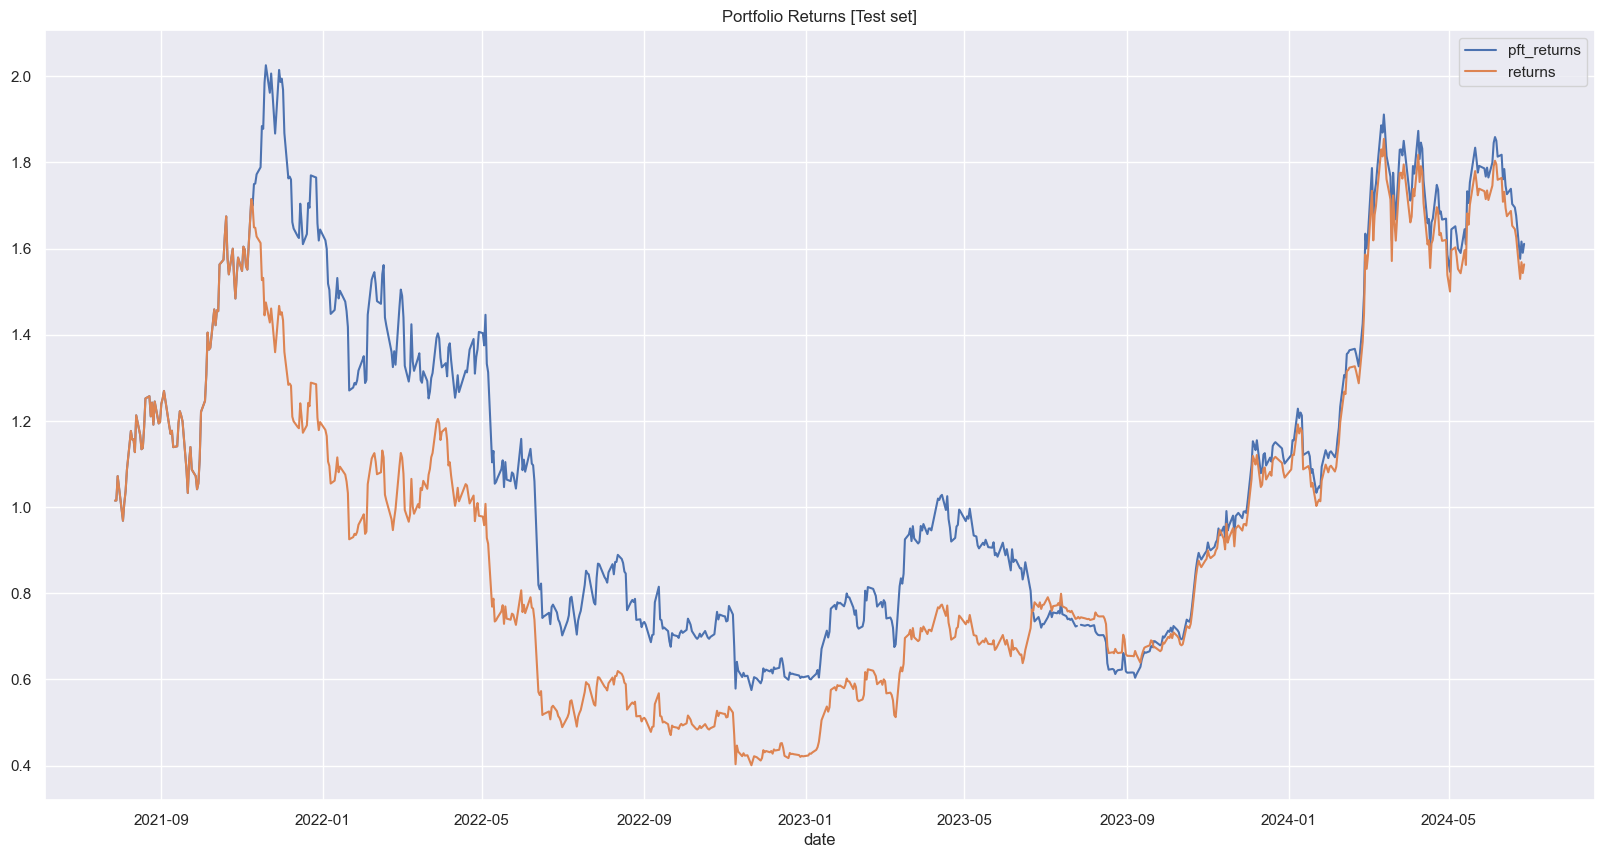

In [106]:
test[["pft_returns", "returns"]].add(1).cumprod().plot(figsize=(20, 10), title="Portfolio Returns [Test set]")

In [116]:
folio = Portfolio(test[["pft_returns"]].dropna(),[1])
bitcoin = Portfolio(test[["bitcoin_returns"]].dropna(),[1])
pop = Population([folio, bitcoin])
stats = pop.summary()
stats.columns = ["Portfolio", "Bitcoin"]
stats

,Portfolio,Bitcoin
Mean,0.13%,0.13%
Annualized Mean,33.48%,32.32%
Variance,0.13%,0.13%
Annualized Variance,33.29%,33.20%
Semi-Variance,0.065%,0.064%
Annualized Semi-Variance,16.33%,16.18%
Standard Deviation,3.63%,3.63%
Annualized Standard Deviation,57.70%,57.62%
Semi-Deviation,2.55%,2.53%
Annualized Semi-Deviation,40.41%,40.22%
